In [ ]:
#Install Libraries
!pip install  imblearn
!pip install transformers
!pip install tensorflow
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.5 MB/s eta 0:00:00


In [ ]:
#Import Libraries
import torch
import numpy as np
import pandas as pd
import spacy
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from datasets import Dataset
from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, auc, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score,precision_recall_fscore_support
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.svm import SVC, LinearSVC
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, GlobalMaxPooling1D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from transformers import RobertaTokenizer, RobertaForSequenceClassification,Trainer, TrainingArguments
from torch.utils.data import DataLoader

In [ ]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. Machine Learning:**use traditional ML models like Logistic Regression,Random Forest,Gradient Boosting Machine, SVMs and Naïve Bayes with features such as TF-IDF

In [ ]:
#Machine Learning
# Load dataset and split data
df = pd.read_csv('/content/drive/MyDrive/FineFoodDataset/labeled_dataset.csv')

# Retain only the required columns for processing
df = df[['review','label']]

#Remove rows with NaN values in the 'review' column
df = df.dropna(subset=['review'])

# Balance the dataset using oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['review']], df['label'])

# Combine back into a balanced DataFrame
balanced_df = pd.DataFrame({'review': X_resampled['review'], 'label': y_resampled})

# Define X and y
X = balanced_df['review']
y = balanced_df['label']

# Encode labels for multiclass classification
le = LabelEncoder()
y = le.fit_transform(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform text data using TF-IDF
tfidf = TfidfVectorizer(max_features=20000,ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Evaluation function
def evaluate_model(y_true, y_pred, y_proba=None, average='binary'):
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba, multi_class='ovr') if y_proba is not None else 'N/A'

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc if roc_auc != 'N/A' else 'N/A'}\n")
    # Compute and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

<ipython-input-4-2324ce764ff7>:3: DtypeWarning: Columns (12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/FineFoodDataset/labeled_dataset.csv')



Random Forest:
Accuracy: 0.9896
Precision: 0.9896
Recall: 0.9896
F1 Score: 0.9896
ROC AUC: 0.9994624631301021



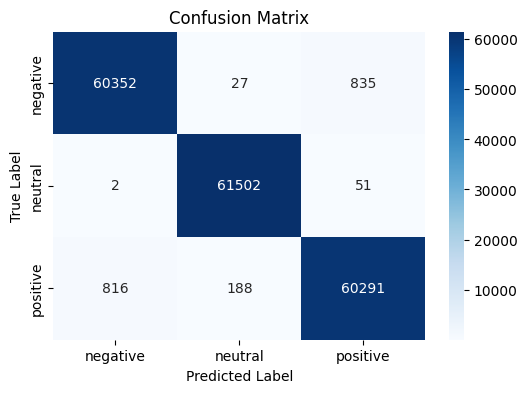

In [ ]:
# Train and evaluate Random Forest
print("\nRandom Forest:")
rf = RandomForestClassifier(min_samples_split=5,min_samples_leaf=2)
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)
y_proba_rf = rf.predict_proba(X_test_tfidf)[:, 1] if len(le.classes_) == 2 else rf.predict_proba(X_test_tfidf)
evaluate_model(y_test, y_pred_rf, y_proba_rf if len(le.classes_) == 2 else y_proba_rf, average='macro' if len(le.classes_) > 2 else 'binary')


Logistic Regression:
Accuracy: 0.8250
Precision: 0.8265
Recall: 0.8250
F1 Score: 0.8256
ROC AUC: 0.9431066037080987



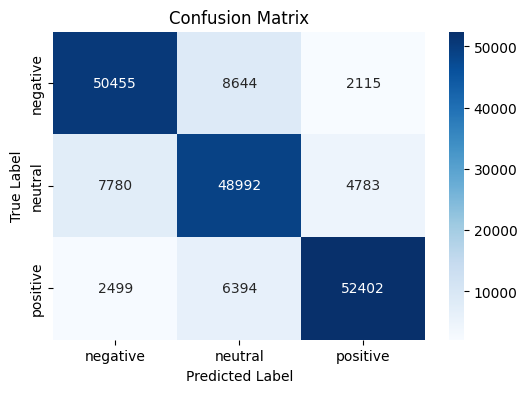


Naive Bayes:
Accuracy: 0.7323
Precision: 0.7344
Recall: 0.7324
F1 Score: 0.7333
ROC AUC: 0.8879307204051576



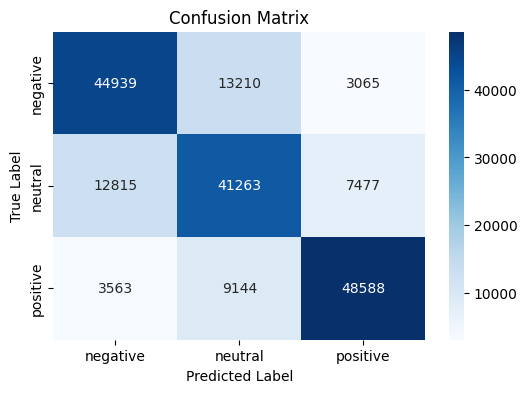

In [ ]:
#Machine Learning
# Train and evaluate Logistic Regression
print("\nLogistic Regression:")
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)
y_pred_lr = log_reg.predict(X_test_tfidf)
y_proba_lr = log_reg.predict_proba(X_test_tfidf)[:, 1] if len(le.classes_) == 2 else log_reg.predict_proba(X_test_tfidf)
evaluate_model(y_test, y_pred_lr, y_proba_lr if len(le.classes_) == 2 else y_proba_lr, average='macro' if len(le.classes_) > 2 else 'binary')

# Train and evaluate Naive Bayes
print("\nNaive Bayes:")
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)
y_proba_nb = nb.predict_proba(X_test_tfidf)[:, 1] if len(le.classes_) == 2 else nb.predict_proba(X_test_tfidf)
evaluate_model(y_test, y_pred_nb, y_proba_nb if len(le.classes_) == 2 else y_proba_nb, average='macro' if len(le.classes_) > 2 else 'binary')


Gradient Boosting Machine:
Accuracy: 0.6663
Precision: 0.6686
Recall: 0.6663
F1 Score: 0.6671
ROC AUC: 0.83751427532092



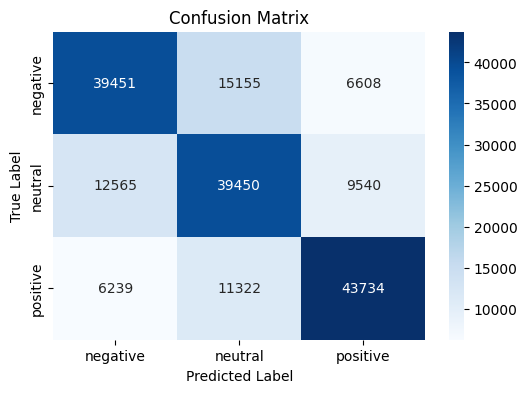

In [ ]:
# Train and evaluate Gradient Boosting Machines (GBM)
print("\nGradient Boosting Machine:")
gbm = GradientBoostingClassifier(min_samples_split=5,min_samples_leaf=2)
gbm.fit(X_train_tfidf, y_train)
y_pred_gbm = gbm.predict(X_test_tfidf)
y_proba_gbm = gbm.predict_proba(X_test_tfidf)[:, 1] if len(le.classes_) == 2 else gbm.predict_proba(X_test_tfidf)
evaluate_model(y_test, y_pred_gbm, y_proba_gbm if len(le.classes_) == 2 else y_proba_gbm, average='macro' if len(le.classes_) > 2 else 'binary')


Support Vector Machine:
Accuracy: 0.8296
Precision: 0.8306
Recall: 0.8297
F1 Score: 0.8300
ROC AUC: 0.9436714845644866



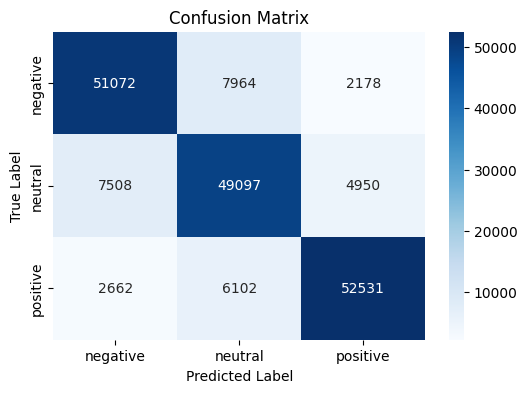

In [ ]:
# Train and evaluate Support Vector Machines (SVM)
print("\nSupport Vector Machine:")
svc = LinearSVC()
svm = CalibratedClassifierCV(svc, cv=5)
# Train the calibrated model
svm.fit(X_train_tfidf, y_train)
# Get probability predictions on the test set
svm_pred_proba = svm.predict_proba(X_test_tfidf)[:, 1] if len(le.classes_) == 2 else svm.predict_proba(X_test_tfidf)
y_pred = svm.predict(X_test_tfidf)
evaluate_model(y_test, y_pred, svm_pred_proba if len(le.classes_) == 2 else svm_pred_proba, average='macro' if len(le.classes_) > 2 else 'binary')

**5- Deep Learning :**Train and evaluate deep learning models:Long Short Term Memory(LSTM),Convolutional Neural Networks (CNNs) and Roberta


In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/FineFoodDataset/labeled_dataset.csv')
X = df['review']
y = df['label']

# Balance the dataset using oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['review']], df['label'])

# Combine back into a balanced DataFrame
balanced_df = pd.DataFrame({'review': X_resampled['review'], 'label': y_resampled})

# Define X and y
X = balanced_df['review']
y = balanced_df['label']

# Encode labels
lb = LabelBinarizer()
y = lb.fit_transform(y)
if y.shape[1] == 1:  # For binary labels
    y = y.ravel()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Check for NaN values and replace with an empty string
X_train = X_train.fillna('')
X_test = X_test.fillna('')

# Ensure all values are strings
X_train = X_train.astype(str)
X_test = X_test.astype(str)

# Tokenize for deep learning models
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Define CNN model
def build_cnn_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=200),
        Conv1D(64, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define LSTM model
def build_lstm_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=200),
        LSTM(128, return_sequences=False),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define evaluation function for multiclass classification
def evaluate_model(model, X_test, y_test, model_name="Model"):
    # Get predicted probabilities
    y_pred_proba = model.predict(X_test)

    # Convert probabilities to class labels (argmax for multiclass)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Convert y_test to integers if it's one-hot encoded
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    # Calculate metrics
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate Multi-class ROC AUC (One-vs-Rest approach)
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    except ValueError:
        roc_auc = None

    # Print results
    print(f"{model_name} - Accuracy: {accuracy:.4f}")
    print(f"{model_name} - Precision (Macro): {precision:.4f}")
    print(f"{model_name} - Recall (Macro): {recall:.4f}")
    print(f"{model_name} - F1 Score (Macro): {f1:.4f}")
    if roc_auc is not None:
        print(f"{model_name} - ROC AUC (Macro): {roc_auc:.4f}")
    else:
        print(f"{model_name} - ROC AUC could not be calculated.")
    # Compute and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

<ipython-input-5-8f0d2fe2e1f0>:2: DtypeWarning: Columns (12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/FineFoodDataset/labeled_dataset.csv')



Training CNN Model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
23009/23009 ━━━━━━━━━━━━━━━━━━━━ 372s 16ms/step - accuracy: 0.7743 - loss: 0.5458 - val_accuracy: 0.9126 - val_loss: 0.2583
Epoch 2/5
23009/23009 ━━━━━━━━━━━━━━━━━━━━ 367s 16ms/step - accuracy: 0.9386 - loss: 0.1870 - val_accuracy: 0.9477 - val_loss: 0.1661
Epoch 3/5
23009/23009 ━━━━━━━━━━━━━━━━━━━━ 364s 16ms/step - accuracy: 0.9689 - loss: 0.0981 - val_accuracy: 0.9591 - val_loss: 0.1362
Epoch 4/5
23009/23009 ━━━━━━━━━━━━━━━━━━━━ 374s 16ms/step - accuracy: 0.9805 - loss: 0.0628 - val_accuracy: 0.9647 - val_loss: 0.1431
Epoch 5/5
23009/23009 ━━━━━━━━━━━━━━━━━━━━ 372s 16ms/step - accuracy: 0.9861 - loss: 0.0448 - val_accuracy: 0.9688 - val_loss: 0.1336
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step
CNN - Accuracy: 0.9688
CNN - Precision (Macro): 0.9691
CNN - Recall (Macro): 0.9688
CNN - F1 Score (Macro): 0.9686
CNN - ROC AUC (Macro): 0.9942


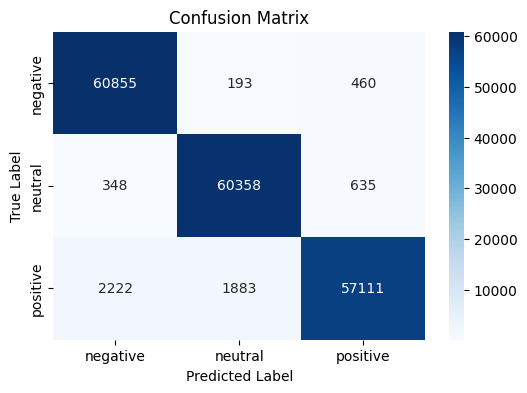

In [ ]:
# Train and evaluate the CNN model
print("\nTraining CNN Model...")
cnn_model = build_cnn_model()
cnn_model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=32)
evaluate_model(cnn_model, X_test_padded, y_test, model_name="CNN")

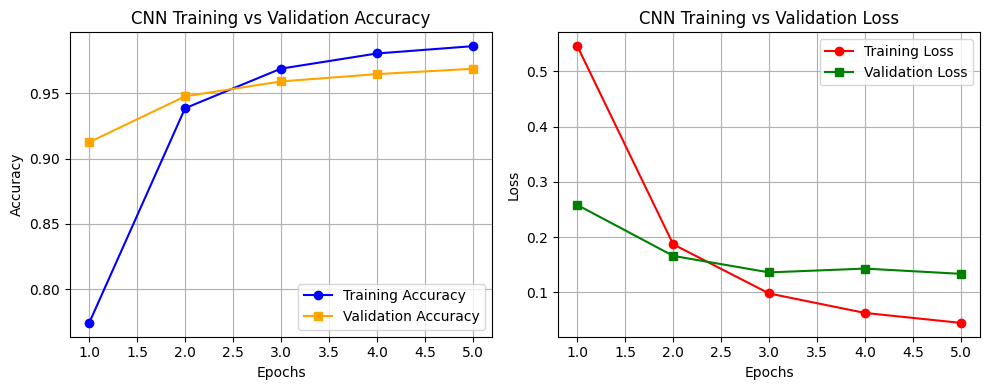

In [ ]:
import matplotlib.pyplot as plt

# CNN Training and Validation Accuracy
epochs = [1, 2, 3, 4, 5]
train_accuracy = [0.7743, 0.9386, 0.9689, 0.9805, 0.9861]  # Updated training accuracy
val_accuracy = [0.9126, 0.9477, 0.9591, 0.9647, 0.9688]    # Updated validation accuracy

# CNN Training and Validation Loss
train_loss = [0.5458, 0.1870, 0.0981, 0.0628, 0.0448]       # Updated training loss
val_loss = [0.2583, 0.1661, 0.1362, 0.1431, 0.1336]          # Updated validation loss

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, marker='o', label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, marker='s', label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, marker='o', label='Training Loss', color='red')
plt.plot(epochs, val_loss, marker='s', label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



Training LSTM Model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
23009/23009 ━━━━━━━━━━━━━━━━━━━━ 5602s 243ms/step - accuracy: 0.5158 - loss: 0.8874 - val_accuracy: 0.8607 - val_loss: 0.3788
Epoch 2/5
23009/23009 ━━━━━━━━━━━━━━━━━━━━ 5663s 246ms/step - accuracy: 0.8951 - loss: 0.2980 - val_accuracy: 0.9340 - val_loss: 0.2034
Epoch 3/5
23009/23009 ━━━━━━━━━━━━━━━━━━━━ 5784s 249ms/step - accuracy: 0.9546 - loss: 0.1428 - val_accuracy: 0.9518 - val_loss: 0.1547
Epoch 4/5
23009/23009 ━━━━━━━━━━━━━━━━━━━━ 5727s 246ms/step - accuracy: 0.9713 - loss: 0.0921 - val_accuracy: 0.9567 - val_loss: 0.1453
Epoch 5/5
23009/23009 ━━━━━━━━━━━━━━━━━━━━ 5734s 247ms/step - accuracy: 0.9785 - loss: 0.0688 - val_accuracy: 0.9655 - val_loss: 0.1226
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 361s 63ms/step
LSTM - Accuracy: 0.9655
LSTM - Precision (Macro): 0.9660
LSTM - Recall (Macro): 0.9654
LSTM - F1 Score (Macro): 0.9653
LSTM - ROC AUC (Macro): 0.9935


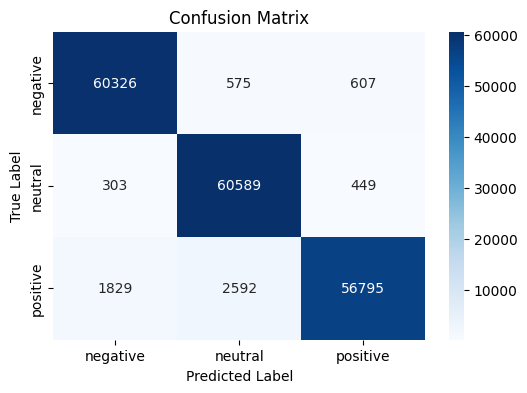

In [ ]:
# Train and evaluate the LSTM model
print("\nTraining LSTM Model...")
lstm_model = build_lstm_model()
lstm_model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=32)
evaluate_model(lstm_model, X_test_padded, y_test, model_name="LSTM")

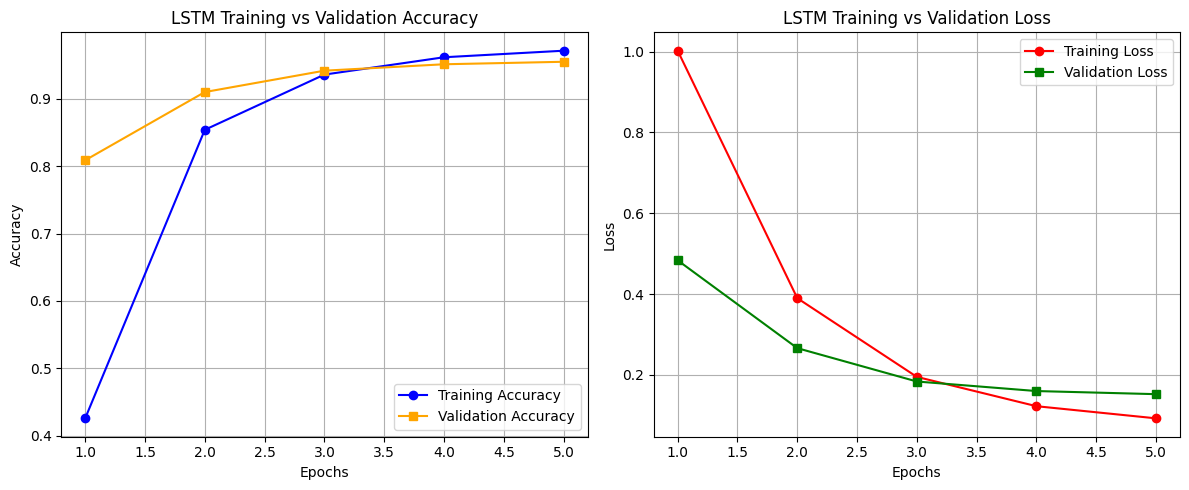

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3, 4, 5]
train_acc = [0.4260, 0.8538, 0.9357, 0.9614, 0.9711]  # Updated training accuracy
val_acc = [0.8087, 0.9098, 0.9415, 0.9510, 0.9547]      # Updated validation accuracy
train_loss = [1.0020, 0.3899, 0.1952, 0.1227, 0.0927]    # Updated training loss
val_loss = [0.4835, 0.2663, 0.1838, 0.1602, 0.1525]       # Updated validation loss

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
axes[0].plot(epochs, train_acc, marker='o', linestyle='-', color="blue", label="Training Accuracy")
axes[0].plot(epochs, val_acc, marker='s', linestyle='-', color="orange", label="Validation Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("LSTM Training vs Validation Accuracy")
axes[0].legend()
axes[0].grid(True)

# Plot Loss
axes[1].plot(epochs, train_loss, marker='o', linestyle='-', color="red", label="Training Loss")
axes[1].plot(epochs, val_loss, marker='s', linestyle='-', color="green", label="Validation Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("LSTM Training vs Validation Loss")
axes[1].legend()
axes[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()


**Roberta**



<ipython-input-4-6964683ce11a>:14: DtypeWarning: Columns (12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/FineFoodDataset/labeled_dataset.csv')  # Replace with the actual file path
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-6964683ce11a>:126: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.372100,0.213905,0.932730,0.935034,0.932703,0.933076,N/A
2,0.105200,0.143158,0.969451,0.970193,0.969426,0.969426,N/A
3,0.104100,0.119042,0.978230,0.978799,0.978208,0.978176,N/A


{'accuracy': 0.9327299200278164, 'precision': 0.9350340741020342, 'recall': 0.9327025696836291, 'f1': 0.933075655898801, 'roc_auc': 'N/A'}
{'accuracy': 0.9694508431849791, 'precision': 0.9701926697153503, 'recall': 0.9694260275064694, 'f1': 0.9694260676240197, 'roc_auc': 'N/A'}
{'accuracy': 0.9782303981223922, 'precision': 0.9787994897312243, 'recall': 0.9782082207572768, 'f1': 0.9781758743121588, 'roc_auc': 'N/A'}


{'accuracy': 0.9782303981223922, 'precision': 0.9787994897312243, 'recall': 0.9782082207572768, 'f1': 0.9781758743121588, 'roc_auc': 'N/A'}
Evaluation Results: {'eval_loss': 0.11904233694076538, 'eval_accuracy': 0.9782303981223922, 'eval_precision': 0.9787994897312243, 'eval_recall': 0.9782082207572768, 'eval_f1': 0.9781758743121588, 'eval_roc_auc': 'N/A', 'eval_runtime': 325.9111, 'eval_samples_per_second': 564.767, 'eval_steps_per_second': 35.298, 'epoch': 3.0}
{'accuracy': 0.9782303981223922, 'precision': 0.9787994897312243, 'recall': 0.9782082207572768, 'f1': 0.9781758743121588, 'roc_auc': 'N/A'}


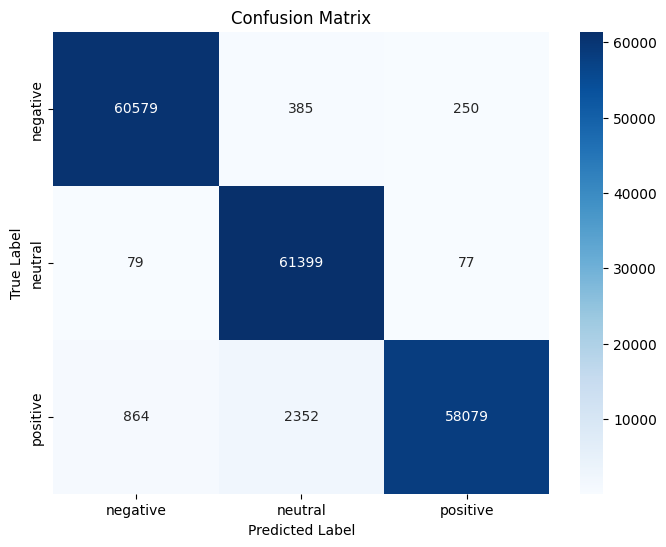

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from imblearn.under_sampling import RandomUnderSampler

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/FineFoodDataset/labeled_dataset.csv')  # Replace with the actual file path
df = df[['review', 'label']].dropna()

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Split data into text and labels
texts = df['review'].tolist()
labels = np.array(df['label'])  # Convert labels to NumPy array

# Tokenization
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize the entire dataset first
encoded_inputs = tokenizer(
    texts,
    max_length=128,
    truncation=True,
    padding="max_length",
    return_tensors="np",
)
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

# Balance the dataset using oversampling
rus = RandomOverSampler(random_state=42)
input_ids_resampled, labels_resampled = rus.fit_resample(input_ids, labels)
attention_masks_resampled, _ = rus.fit_resample(attention_masks, labels)

# Get indices of resampled data to filter texts
indices_resampled = rus.sample_indices_
texts_resampled = [texts[i] for i in indices_resampled]  # Get the corresponding resampled texts

# Combine back into a balanced DataFrame
balanced_df = pd.DataFrame({'processed_review': texts_resampled, 'label': labels_resampled})

# Train-test split
X_train_ids, X_test_ids, X_train_masks, X_test_masks, y_train, y_test = train_test_split(
    input_ids_resampled,
    attention_masks_resampled,
    labels_resampled,
    test_size=0.2,
    random_state=42,
)

# Custom Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_masks[idx], dtype=torch.long),
            "label": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Create datasets
train_dataset = SentimentDataset(X_train_ids, X_train_masks, y_train)
val_dataset = SentimentDataset(X_test_ids, X_test_masks, y_test)

# Roberta Model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(le.classes_))

# Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    pred_proba = pred.predictions  # probabilities for each class

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")

    # Compute ROC-AUC score for multi-class
    try:
        roc_auc = roc_auc_score(labels, pred_proba, multi_class="ovr", average="macro", labels=np.unique(labels))
    except ValueError:
        roc_auc = "N/A"  # Handle edge cases (e.g., single class in test set)

    metrics = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc if roc_auc != "N/A" else "N/A",
    }
    print(metrics)
    return metrics

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    report_to="none",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

# Save the model and tokenizer
model.save_pretrained("./roberta_sentiment")
tokenizer.save_pretrained("./roberta_sentiment")

# Generate Confusion Matrix
predictions = trainer.predict(val_dataset)  # Get predictions
preds = np.argmax(predictions.predictions, axis=-1)  # Get predicted class indices
y_true = predictions.label_ids  # Get true labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


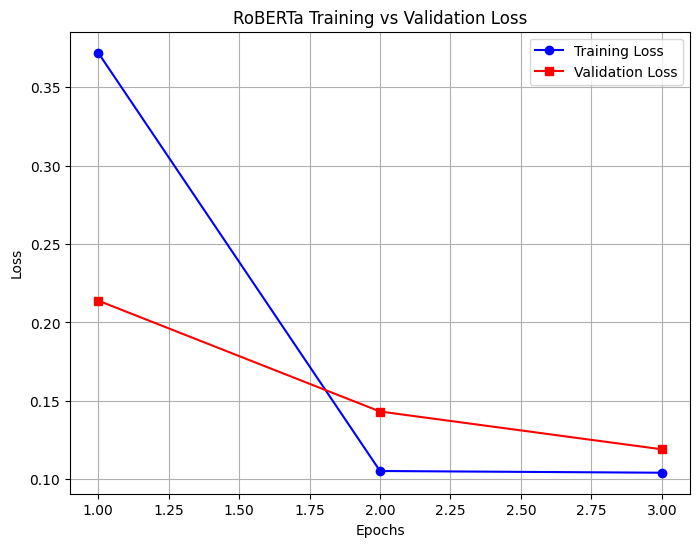

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3]
train_loss = [0.372100, 0.105200, 0.104100]
val_loss = [0.213905, 0.143158, 0.119042]
accuracy = [0.932730, 0.969451, 0.978230]

# Create figure
plt.figure(figsize=(8, 6))

# Plot Loss
plt.plot(epochs, train_loss, marker='o', linestyle='-', color="blue", label="Training Loss")
plt.plot(epochs, val_loss, marker='s', linestyle='-', color="red", label="Validation Loss")

# Labels & Titles
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("RoBERTa Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Show Plot
plt.show()
